# SAM3 Dense Tracking (Single-GPU)

## 1. Setup

In [1]:
sam3_root = "/home/marksm/sam3"
# checkpoint_file = f"{sam3_root}/assets/checkpoints/prod_v12_sam2_internal_shared_dth0.5_newdet0.7_assth0.1_nms0.1.pt"
checkpoint_file = f"{sam3_root}/assets/checkpoints/sam3_prod_v12_video.pt"
bpe_path = f"{sam3_root}/assets/bpe_simple_vocab_16e6.txt.gz"


In [3]:
import os
from glob import glob
from sam3.model.sam3_model_web import Sam3Model
from sam3.model.sam3_model_web_multigpu import Sam3ModelMultiGPU

GPUS_TO_USE = [0, 1, 2, 3, 4, 5, 6, 7]
# set the GPUs to use via "CUDA_VISIBLE_DEVICES"
assert all(isinstance(i, int) for i in GPUS_TO_USE)
assert GPUS_TO_USE == sorted(set(GPUS_TO_USE))
os.environ["CUDA_VISIBLE_DEVICES"] = ",".join(str(i) for i in GPUS_TO_USE)


model_wrapper = Sam3ModelMultiGPU( # use Sam3Model for running on single GPU
    bpe_path=bpe_path,
    checkpoint_path=checkpoint_file,
    strict_state_dict_loading=True,
)

Enabled the use of perflib.
Enabled the use of perflib.Enabled the use of perflib.

Enabled the use of perflib.
Enabled the use of perflib.
Enabled the use of perflib.
Enabled the use of perflib.
Enabled the use of perflib.


[W930 01:25:51.165566324 Utils.hpp:137] Warning: Environment variable NCCL_ASYNC_ERROR_HANDLING is deprecated; use TORCH_NCCL_ASYNC_ERROR_HANDLING instead (function operator())
[W930 01:25:52.465900970 Utils.hpp:137] Warning: Environment variable NCCL_ASYNC_ERROR_HANDLING is deprecated; use TORCH_NCCL_ASYNC_ERROR_HANDLING instead (function operator())
[W930 01:25:56.196957306 Utils.hpp:137] Warning: Environment variable NCCL_ASYNC_ERROR_HANDLING is deprecated; use TORCH_NCCL_ASYNC_ERROR_HANDLING instead (function operator())


NCCL version 2.26.2+cuda12.2


[W930 01:25:56.433615086 Utils.hpp:137] Warning: Environment variable NCCL_ASYNC_ERROR_HANDLING is deprecated; use TORCH_NCCL_ASYNC_ERROR_HANDLING instead (function operator())
[W930 01:25:56.576513245 Utils.hpp:137] Warning: Environment variable NCCL_ASYNC_ERROR_HANDLING is deprecated; use TORCH_NCCL_ASYNC_ERROR_HANDLING instead (function operator())
[W930 01:25:56.577711413 Utils.hpp:137] Warning: Environment variable NCCL_ASYNC_ERROR_HANDLING is deprecated; use TORCH_NCCL_ASYNC_ERROR_HANDLING instead (function operator())
[W930 01:25:56.577757377 Utils.hpp:137] Warning: Environment variable NCCL_ASYNC_ERROR_HANDLING is deprecated; use TORCH_NCCL_ASYNC_ERROR_HANDLING instead (function operator())
[W930 01:25:56.579129512 Utils.hpp:137] Warning: Environment variable NCCL_ASYNC_ERROR_HANDLING is deprecated; use TORCH_NCCL_ASYNC_ERROR_HANDLING instead (function operator())


### Visualization utils

In [4]:

import matplotlib.pyplot as plt
from utils import visualize_formatted_frame_output, prepare_masks_for_visualization


[2025-09-30 01:25:57] h200-157-153:3419797:3421749 [0] configure_nvls_option:287 NCCL WARN NET/OFI Could not find ncclGetVersion symbol

[2025-09-30 01:25:57] h200-157-153:3419399:3421762 [0] configure_nvls_option:287 NCCL WARN NET/OFI Could not find ncclGetVersion symbol

[2025-09-30 01:25:57] h200-157-153:3419800:3421755 [0] configure_nvls_option:287 NCCL WARN NET/OFI Could not find ncclGetVersion symbol

[2025-09-30 01:25:57] h200-157-153:3419802:3421752 [0] configure_nvls_option:287 NCCL WARN NET/OFI Could not find ncclGetVersion symbol

[2025-09-30 01:25:57] h200-157-153:3419796:3421756 [0] configure_nvls_option:287 NCCL WARN NET/OFI Could not find ncclGetVersion symbol

[2025-09-30 01:25:57] h200-157-153:3419801:3421759 [0] configure_nvls_option:287 NCCL WARN NET/OFI Could not find ncclGetVersion symbol

[2025-09-30 01:25:57] h200-157-153:3419798:3421750 [0] configure_nvls_option:287 NCCL WARN NET/OFI Could not find ncclGetVersion symbol

[2025-09-30 01:25:57] h200-157-153:34197

## 2. Running inference

In [5]:
# this video has 6 objects
video_frames_dir = f"{sam3_root}/assets/videos/0001"
prompt_text_str = "person"

# this video has ~80 objects
# video_frames_dir = "/checkpoint/sam3/shared/webdemo/data/ta/static/gallery/selected_examples/0018/rgb"
# prompt_text_str = "horse"

### Opening an inference session on this video

In [6]:
response = model_wrapper.handle_request(
    request=dict(
        type="start_session",
        resource_path=video_frames_dir,
    )
)
session_id = response["session_id"]

# "image_files" is only needed for visualization purposes (not used by the model)
image_files = glob(os.path.join(video_frames_dir, "*.jpg"))
try:
    # integer sort instead of string sort (so that e.g. "2.jpg" is before "11.jpg")
    image_files.sort(key=lambda p: int(os.path.splitext(os.path.basename(p))[0]))
except ValueError:
    # fallback to lexicographic sort if the format is not "<frame_index>.jpg"
    print(
        f'frame names are not in "<frame_index>.jpg" format: {image_files[:5]=}, '
        f"falling back to lexicographic sort."
    )
    image_files.sort()

frame loading (JPEG): 100%|██████████| 270/270 [00:06<00:00, 40.11it/s]


### Adding a text prompt on frame 0 and propagation throughout the video

Note that the first call might be slower due to setting up buffers. **You can rerun all the cells below when measuring speed.**

In [7]:
# note: in case you already ran one text prompt and now want to switch to another text prompt
# it's required to reset the session first (otherwise the results would be wrong)
_ = model_wrapper.handle_request(
    request=dict(
        type="reset_session",
        session_id=session_id,
    )
)

In [8]:
frame_idx = 0  # add a text prompt on frame 0
response = model_wrapper.handle_request(
    request=dict(
        type="add_prompt",
        session_id=session_id,
        frame_index=frame_idx,
        text=prompt_text_str,
    )
)
out = response["outputs"]

/checkpoint/sam3/ronghanghu/anaconda3/envs/onevision_sam3/lib/python3.10/site-packages/torch/nn/functional.py:5015: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/checkpoint/sam3/ronghanghu/anaconda3/envs/onevision_sam3/lib/python3.10/site-packages/torch/nn/functional.py:5015: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/checkpoint/sam3/ronghanghu/anaconda3/envs/onevision_sam3/lib/python3.10/site-packages/torch/nn/functional.py:5015: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. Se

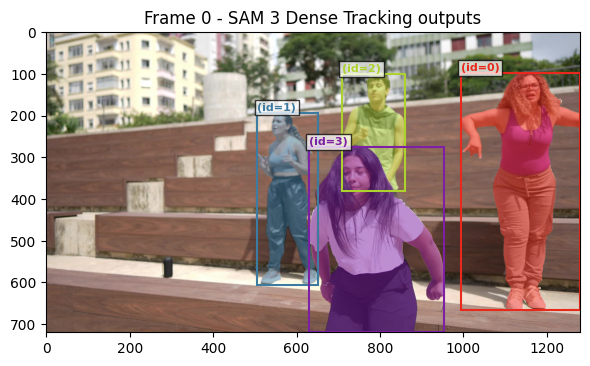

In [9]:
plt.close("all")
visualize_formatted_frame_output(
    frame_idx,
    image_files,
    outputs_list=[prepare_masks_for_visualization({frame_idx: out})],
    titles=["SAM 3 Dense Tracking outputs"],
    figsize=(6, 4),
)

In [10]:
# we will just propagate from frame 0 to the end of the video
outputs_per_frame = {}
for response in model_wrapper.handle_stream_request(
    request=dict(
        type="propagate_in_video",
        session_id=session_id,
    )
):
    outputs_per_frame[response["frame_index"]] = response["outputs"]
outputs_per_frame = prepare_masks_for_visualization(outputs_per_frame)

propagate_in_video: 100%|██████████| 270/270 [00:08<00:00, 30.70it/s]
propagate_in_video: 0it [00:00, ?it/s]


frame 0


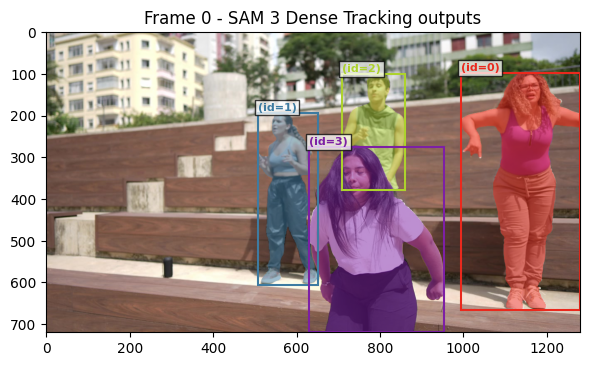

frame 60


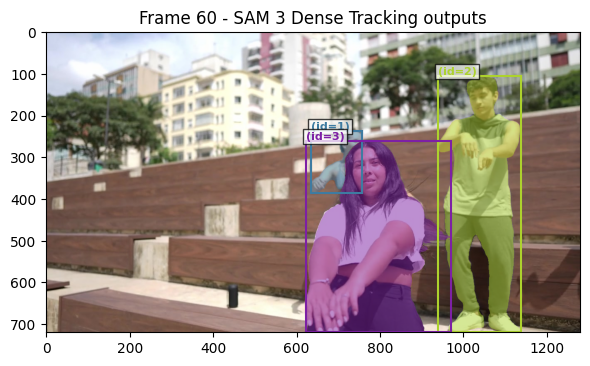

frame 120


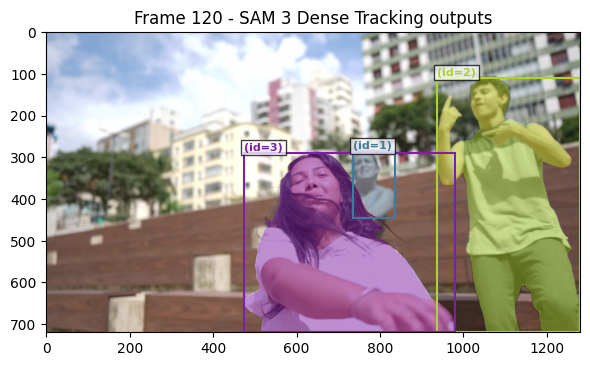

frame 180


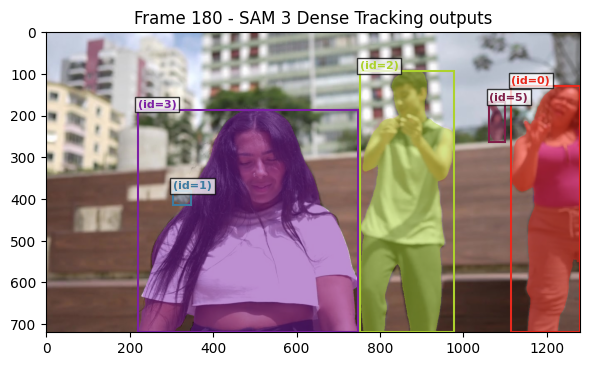

frame 240


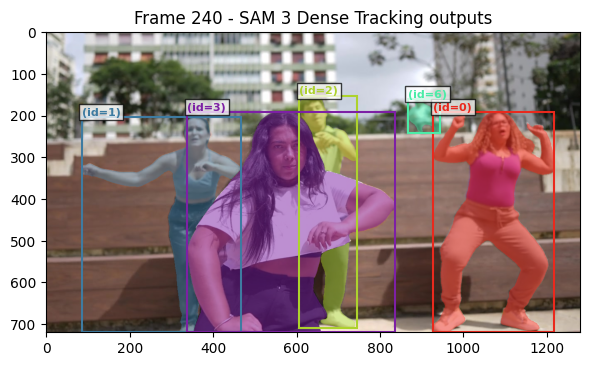

In [11]:
vis_frame_stride = 60
plt.close("all")
for frame_idx in range(0, len(outputs_per_frame), vis_frame_stride):
    print(f"frame {frame_idx}")
    visualize_formatted_frame_output(
        frame_idx,
        image_files,
        outputs_list=[outputs_per_frame],
        titles=["SAM 3 Dense Tracking outputs"],
        figsize=(6, 4),
    )
